In [135]:

from data.make_dataset import load_data
from alphas.alpha import FutureLookupStrategy, NthValueStrategy, AggregatedFutureStrategy
from alphas.backtest import Backtester

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [136]:
all_stats = []
mi_tuples  = []
equity_curves = []

## Run all strategies

#### Run basic hardcoded next value lookahead

In [137]:
TS, BIDS, ASKS = load_data()

def add_final_equity(engine, stats: dict, key: str = "Final equity ($)") -> dict:
    stats[key] = float(engine.equity_curve().iloc[-1])
    return stats

engine = Backtester(TS, BIDS, ASKS, FutureLookupStrategy())
engine.run()

label = "FutureLookupStrategy"
mi_tuples.append((label, None, None))

stats = engine.stats("desc")
all_stats.append(add_final_equity(engine, stats))

equity_curves.append((label, engine.equity_curve()))

#### Run N'th value lookahead

In [138]:
for i in [*range(1, 6), 10, 15, 30, 60, 120]:
    engine = Backtester(TS, BIDS, ASKS, NthValueStrategy(offset=i))
    engine.run()

    label = f"NthValueStrategy‑{i}"
    mi_tuples.append(("NthValueStrategy", i, None))

    stats = engine.stats("desc")
    all_stats.append(add_final_equity(engine, stats))

    equity_curves.append((label, engine.equity_curve()))

#### Run Agg window

In [139]:
agg_fns = [("mean", np.mean), ("max", np.max),
           ("min",  np.min),  ("median", np.median)]

for w in [*range(2, 6), 10, 15, 30, 60, 120]:
    for name, fn in agg_fns:
        engine = Backtester(TS, BIDS, ASKS,
                            AggregatedFutureStrategy(window=w, agg_fn=fn))
        engine.run()

        label = f"Aggregated‑{name}‑{w}"
        mi_tuples.append(("AggregatedFutureStrategy", w, name))

        stats = engine.stats("desc")
        all_stats.append(add_final_equity(engine, stats))

        equity_curves.append((label, engine.equity_curve()))


## Analyze stats

Stats generation is in backtester code, no further functionality is used beyond basic display of stats.

In [140]:
# import pandas as pd

index = pd.MultiIndex.from_tuples(mi_tuples, names=["strategy", "window/lead", "agg_fn"])
# pd.DataFrame(all_stats, index = index)

In [142]:

equity_final_stats = (
    pd.DataFrame(all_stats, index=index)["Final equity ($)"]
      .unstack()
      .round(2)
      .fillna("") 
)

equity_final_stats.to_csv("../reports/equity_final_stats.csv")

equity_final_stats.to_markdown(
    buf="../reports/equity_final_stats.md",
    tablefmt="github"
)


equity_final_stats


agg_fn                                 NaN   max  mean median   min
strategy                 window/lead                               
AggregatedFutureStrategy 2                  1.28  1.34   1.34  1.31
                         3                  1.28  1.38   1.37  1.31
                         4                  1.28   1.4   1.39   1.3
                         5                  1.28  1.42    1.4  1.29
                         10                 1.25  1.43   1.43  1.25
                         15                 1.23  1.42    1.4  1.22
                         30                 1.18  1.37   1.36  1.17
                         60                 1.14  1.29    1.3  1.12
                         120                1.09  1.22   1.23  1.08
FutureLookupStrategy     NaN          1.25                         
NthValueStrategy         1            1.25                         
                         2            1.38                         
                         3            1.41                         
                         4            1.42                         
                         5            1.42                         
                         10           1.38                         
                         15           1.33                         
                         30           1.23                         
                         60           1.16                         
                         120          1.11

In [110]:
portfolio_efficiency_stats = pd.DataFrame(all_stats, index = index)["Portfolio efficiency"].unstack().round(1).fillna("")
portfolio_efficiency_stats.to_csv("../reports/portfolio_efficiency_stats.csv")

out_path = "../reports/portfolio_efficiency_stats.md"
portfolio_efficiency_stats.to_markdown(buf=out_path, tablefmt="github")

portfolio_efficiency_stats

agg_fn                                NaN  max mean median  min
strategy                 window/lead                           
AggregatedFutureStrategy 2                 1.0  1.5    1.5  1.9
                         3                 0.9  1.6    1.6  2.2
                         4                 0.9  1.7    1.7  2.3
                         5                 0.8  1.8    1.7  2.5
                         10                0.7  1.8    1.8  3.0
                         15                0.6  1.8    1.7  3.2
                         30                0.5  1.6    1.6  3.6
                         60                0.4  1.3    1.3  4.0
                         120               0.2  1.0    1.0  4.2
FutureLookupStrategy     NaN          1.1                      
NthValueStrategy         1            1.1                      
                         2            1.6                      
                         3            1.7                      
                         4            1.8                      
                         5            1.7                      
                         10           1.6                      
                         15           1.4                      
                         30           1.1                      
                         60           0.8                      
                         120          0.5

In [111]:
sharpe_stats = (pd.DataFrame(all_stats, index = index)["Annualized Sharpe"].unstack() / 1000).round(1).fillna("")
sharpe_stats.to_csv("../reports/sharpe_stats.csv")

out_path = "../reports/sharpe_stats.md"
sharpe_stats.to_markdown(buf=out_path, tablefmt="github")

sharpe_stats

agg_fn                                NaN  max mean median  min
strategy                 window/lead                           
AggregatedFutureStrategy 2                 1.2  1.8    1.8  1.9
                         3                 1.2  2.0    1.9  2.0
                         4                 1.2  2.1    2.1  2.0
                         5                 1.2  2.2    2.1  2.0
                         10                1.0  2.3    2.2  2.0
                         15                0.9  2.2    2.1  1.9
                         30                0.7  2.0    1.9  1.7
                         60                0.6  1.6    1.6  1.4
                         120               0.4  1.1    1.2  1.1
FutureLookupStrategy     NaN          1.3                      
NthValueStrategy         1            1.3                      
                         2            2.0                      
                         3            2.1                      
                         4            2.1                      
                         5            2.1                      
                         10           2.0                      
                         15           1.7                      
                         30           1.2                      
                         60           0.8                      
                         120          0.6

In [112]:
returns_stats = (pd.DataFrame(all_stats, index = index)["Annualized return (linear)"].unstack() / 10000).round(1).fillna("")
returns_stats.to_csv("../reports/returns_stats.csv")

out_path = "../reports/sharpe_stats.md"
returns_stats.to_markdown(buf=out_path, tablefmt="github")

returns_stats

agg_fn                                NaN  max mean median  min
strategy                 window/lead                           
AggregatedFutureStrategy 2                 2.7  3.3    3.3  3.0
                         3                 2.8  3.7    3.6  3.0
                         4                 2.7  3.9    3.8  2.9
                         5                 2.7  4.1    3.9  2.8
                         10                2.5  4.2    4.1  2.5
                         15                2.2  4.1    3.9  2.2
                         30                1.8  3.6    3.5  1.7
                         60                1.3  2.9    2.9  1.2
                         120               0.9  2.1    2.2  0.8
FutureLookupStrategy     NaN          2.5                      
NthValueStrategy         1            2.5                      
                         2            3.7                      
                         3            4.0                      
                         4            4.1                      
                         5            4.1                      
                         10           3.7                      
                         15           3.2                      
                         30           2.3                      
                         60           1.6                      
                         120          1.1

In [113]:
drawdown_stats = (pd.DataFrame(all_stats, index = index)["Max drawdown"].unstack() * 1000).round(1).fillna("")
drawdown_stats.to_csv("../reports/drawdown_stats.csv")

out_path = "../reports/drawdown_stats.md"
drawdown_stats.to_markdown(buf=out_path, tablefmt="github")

drawdown_stats

agg_fn                                NaN  max mean median  min
strategy                 window/lead                           
AggregatedFutureStrategy 2                 6.1  3.4    3.4  1.9
                         3                 6.1  3.0    2.2  1.3
                         4                 6.1  3.1    3.0  1.2
                         5                 6.1  3.1    2.1  1.1
                         10                6.2  1.6    1.6  1.0
                         15                5.9  1.6    1.7  0.8
                         30                6.2  1.6    1.6  0.8
                         60                6.3  1.7    1.7  0.6
                         120               9.3  6.0    6.0  0.6
FutureLookupStrategy     NaN          5.9                      
NthValueStrategy         1            5.9                      
                         2            1.9                      
                         3            1.9                      
                         4            1.7                      
                         5            1.9                      
                         10           1.7                      
                         15           2.0                      
                         30           3.1                      
                         60           6.1                      
                         120          8.3

## Plotting interactions of stats

In [114]:
df = pd.DataFrame(all_stats, index = index)

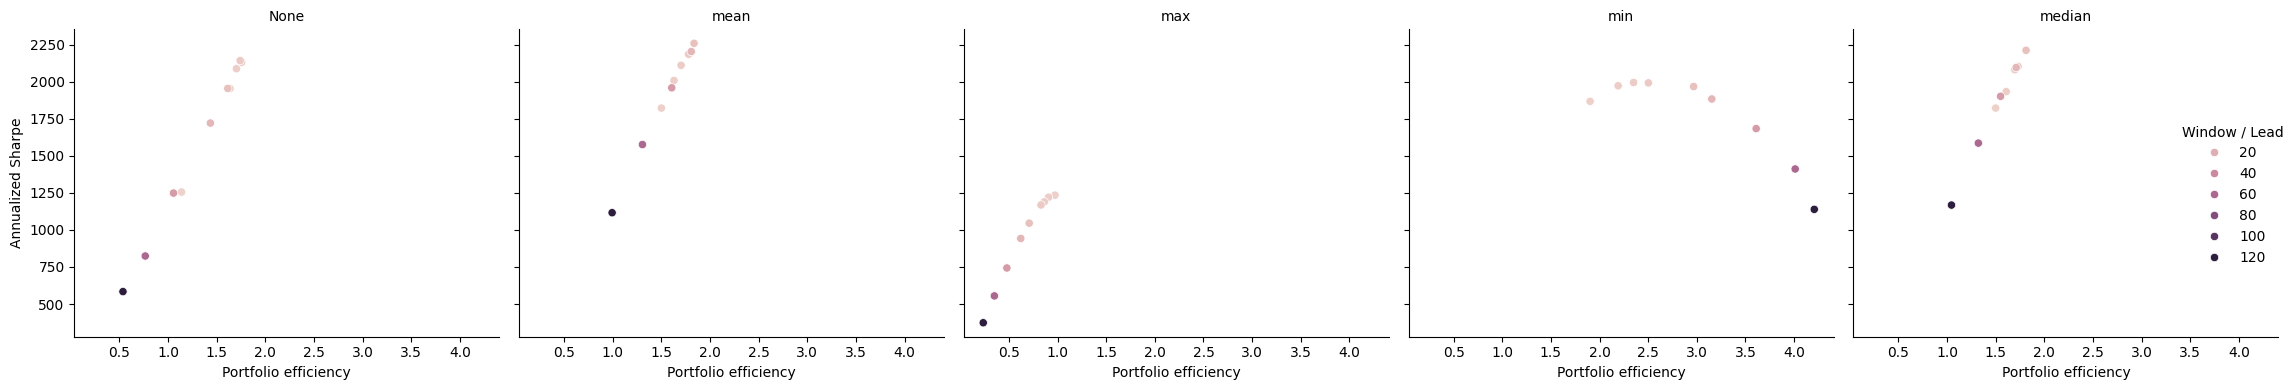

In [115]:

plot_df = (
    df.reset_index()  
      .rename(columns={"strategy": "group"})
)

plot_df["agg_fn"]      = plot_df["agg_fn"].fillna("None")
plot_df["window/lead"] = plot_df["window/lead"].fillna(1.0)

norm = Normalize(
    vmin=plot_df["window/lead"].min(),
    vmax=plot_df["window/lead"].max()
)

g = sns.relplot(
        data   = plot_df,
        kind   = "scatter",
        x      = "Portfolio efficiency",
        y      = "Annualized Sharpe",
        hue    = "window/lead",
        hue_norm = norm,
        col    = "agg_fn",
        edgecolor = "w",
        linewidth = .5,
        height = 4,
        aspect = 1.1
)

g.set_titles(col_template="{col_name}")
g.legend.set_title("Window / Lead")

fig = g.fig 
fig.tight_layout()
fig.savefig(
    "../reports/figures/strategy_scatter.png",
    dpi=300,
    bbox_inches="tight"
)

# optional on‑screen preview
plt.show()

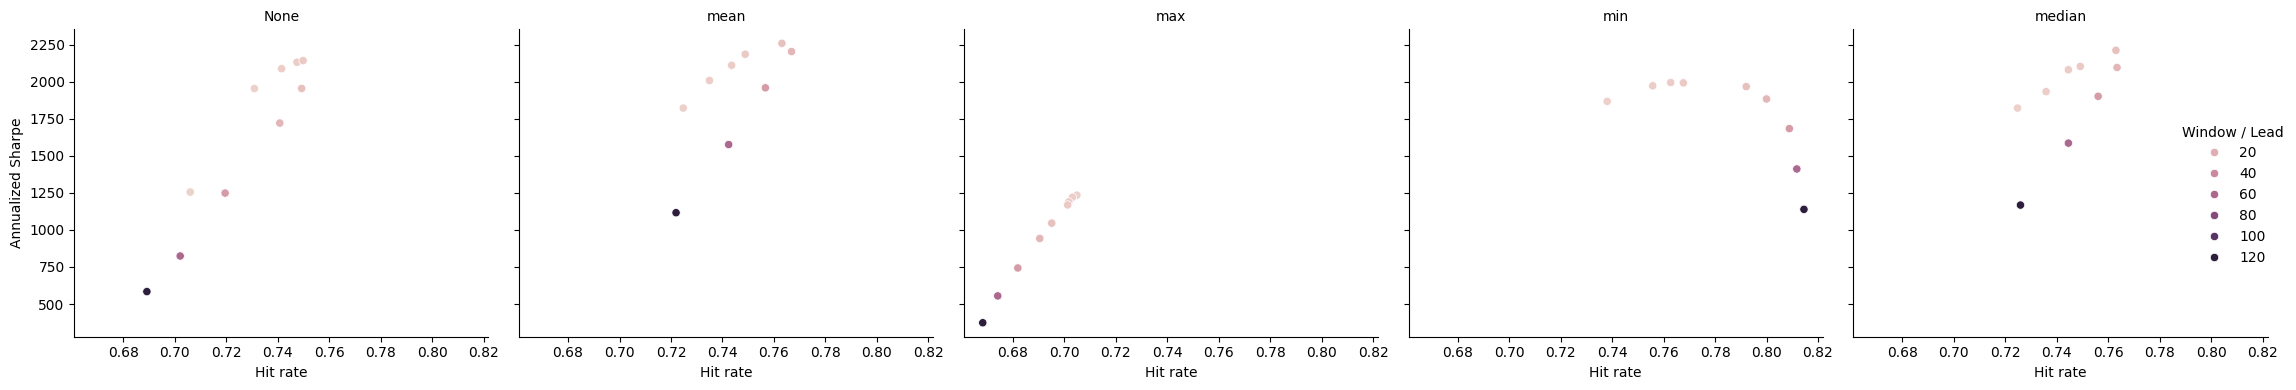

In [116]:

plot_df = (
    df.reset_index()
      .rename(columns={"strategy": "group"})
)

plot_df["agg_fn"]      = plot_df["agg_fn"].fillna("None")
plot_df["window/lead"] = plot_df["window/lead"].fillna(1.0)

norm = Normalize(
    vmin=plot_df["window/lead"].min(),
    vmax=plot_df["window/lead"].max()
)


g = sns.relplot(
        data   = plot_df,
        kind   = "scatter",
        x      = "Hit rate",
        y      = "Annualized Sharpe",
        hue    = "window/lead",
        hue_norm = norm,
        col    = "agg_fn",
        edgecolor = "w",
        linewidth = .5,
        height = 4,
        aspect = 1.1
)

g.set_titles(col_template="{col_name}")
g.legend.set_title("Window / Lead")

fig = g.fig 
fig.tight_layout()
fig.savefig(
    "../reports/figures/hitrate_vs_sharpe.png",
    dpi=300,
    bbox_inches="tight"
)

# optional preview
plt.show()

## Picking optimal stats

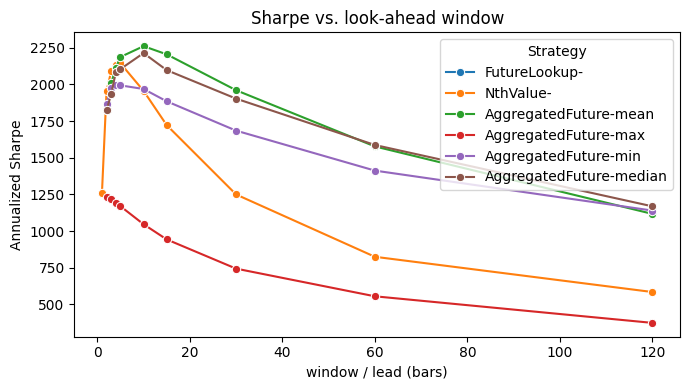

In [117]:

mask     = plot_df["window/lead"].notna()
param_df = plot_df[mask].copy()

param_df["line"] = (
      param_df["group"]
        .str.replace("Strategy$", "", regex=True)          # drop suffix
    + param_df["agg_fn"].mask(param_df["agg_fn"].eq("None"), "")
        .radd("-", fill_value="")                          # "-mean", "-max", …
)

fig, ax = plt.subplots(figsize=(7, 4))
sns.lineplot(
    data   = param_df.sort_values("window/lead"),
    x      = "window/lead",
    y      = "Annualized Sharpe",
    hue    = "line",
    marker = "o",
    ax     = ax
)

ax.set_title("Sharpe vs. look‑ahead window")
ax.set_xlabel("window / lead (bars)")
ax.set_ylabel("Annualized Sharpe")
ax.legend(title="Strategy")
fig.tight_layout()

fig.savefig(
    "../reports/figures/sharpe_vs_window.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

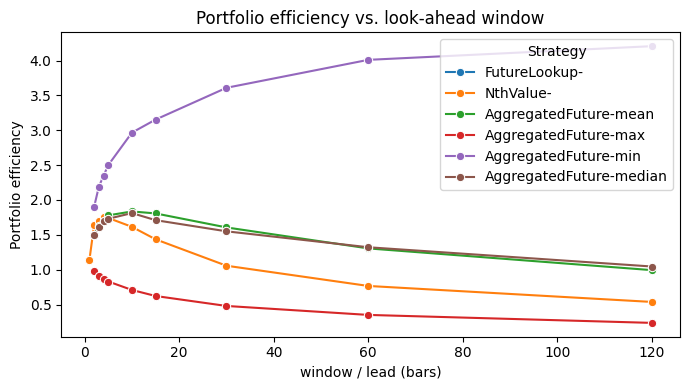

In [134]:

mask     = plot_df["window/lead"].notna()
param_df = plot_df[mask].copy()

param_df["line"] = (
      param_df["group"]
        .str.replace("Strategy$", "", regex=True)
    + param_df["agg_fn"].mask(param_df["agg_fn"].eq("None"), "")
        .radd("-", fill_value="")      
)

fig, ax = plt.subplots(figsize=(7, 4))

sns.lineplot(
    data   = param_df.sort_values("window/lead"),
    x      = "window/lead",
    y      = "Portfolio efficiency",
    hue    = "line",
    marker = "o",
    ax     = ax
)

ax.set_title("Portfolio efficiency vs. look‑ahead window")
ax.set_xlabel("window / lead (bars)")
ax.set_ylabel("Portfolio efficiency")
ax.legend(title="Strategy")
fig.tight_layout()

fig.savefig(
    "../reports/figures/portfolio_efficiency_vs_window.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


## Plotting all pnls

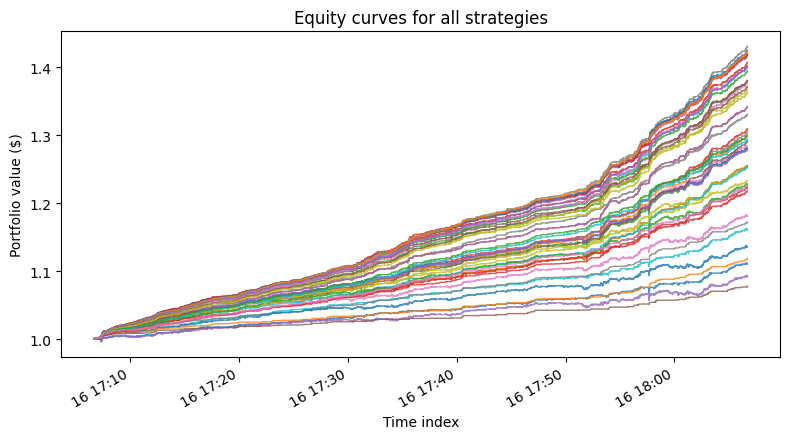

In [130]:
# Combine and plot without legend
fig, ax = plt.subplots(figsize=(8, 4.5))

for label, curve in equity_curves:
    curve.plot(ax=ax, lw=1, alpha=0.8, label=label)

ax.set_title("Equity curves for all strategies")
ax.set_xlabel("Time index")
ax.set_ylabel("Portfolio value ($)")

# ax.legend(fontsize="small", ncol=2)
fig.tight_layout()

fig.savefig("../reports/figures/all_equity_curves.png",
            dpi=300, bbox_inches="tight")
plt.show()


## Final solution that doesn't violate any requirements

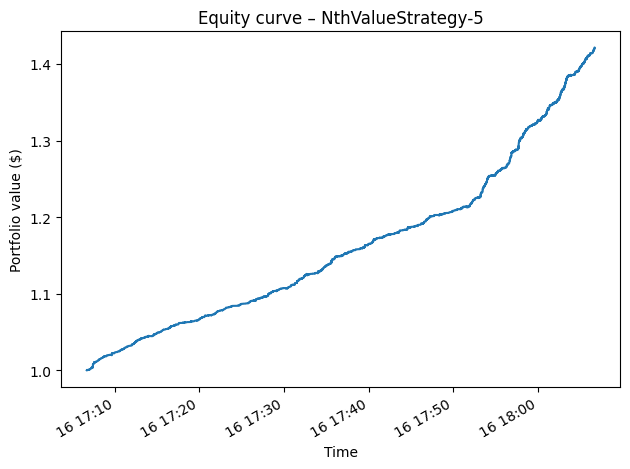

In [148]:

nth5_curve = [i[1] for i in equity_curves if i[0] == 'NthValueStrategy‑5'][0]


ax  = nth5_curve.plot()
fig = ax.get_figure() 

ax.set_title("Equity curve – NthValueStrategy‑5")
ax.set_xlabel("Time")
ax.set_ylabel("Portfolio value ($)")
fig.tight_layout()

fig.savefig(
    "../reports/figures/final_equity_curve.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


## Correlations between returns

In [133]:

eq_df = pd.concat({label: curve for label, curve in equity_curves}, axis=1)

corr_df = (
    eq_df.pct_change() 
         .dropna()
         .corr() 
         .round(2)
)

corr_df.to_csv("../reports/equity_corr_matrix.csv")

out_path = "../reports/equity_corr_head.md"

corr_df.iloc[:10, :10].to_markdown(buf=out_path, tablefmt="github")

corr_df.iloc[:10, :10]


,FutureLookupStrategy,NthValueStrategy‑1,NthValueStrategy‑2,NthValueStrategy‑3,NthValueStrategy‑4,NthValueStrategy‑5,NthValueStrategy‑10,NthValueStrategy‑15,NthValueStrategy‑30,NthValueStrategy‑60
FutureLookupStrategy,1.00,1.00,0.72,0.68,0.65,0.64,0.59,0.56,0.54,0.59
NthValueStrategy‑1,1.00,1.00,0.72,0.68,0.65,0.64,0.59,0.56,0.54,0.59
NthValueStrategy‑2,0.72,0.72,1.00,0.84,0.80,0.78,0.70,0.66,0.61,0.55
NthValueStrategy‑3,0.68,0.68,0.84,1.00,0.87,0.83,0.73,0.69,0.63,0.55
NthValueStrategy‑4,0.65,0.65,0.80,0.87,1.00,0.87,0.76,0.71,0.64,0.56
NthValueStrategy‑5,0.64,0.64,0.78,0.83,0.87,1.00,0.78,0.72,0.65,0.57
NthValueStrategy‑10,0.59,0.59,0.70,0.73,0.76,0.78,1.00,0.81,0.69,0.59
NthValueStrategy‑15,0.56,0.56,0.66,0.69,0.71,0.72,0.81,1.00,0.74,0.62
NthValueStrategy‑30,0.54,0.54,0.61,0.63,0.64,0.65,0.69,0.74,1.00,0.69
NthValueStrategy‑60,0.59,0.59,0.55,0.55,0.56,0.57,0.59,0.62,0.69,1.00
